# Requirements

In [1]:
from IPython.display import clear_output
!pip install itk
clear_output()
import sys
import itk
from ipywidgets import interactive, IntSlider
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
base = ""
fixedImageFile = "/content/drive/MyDrive/ITK Registration/VF-MRT1-1014-1174.vtk"
movingImageFile = "/content/drive/MyDrive/ITK Registration/VF-MRT2-1014-1174.vtk"
outputImageFile = "/content/drive/MyDrive/Registration/registered.vtk"
differenceImageAfterFile = "/content/drive/MyDrive/Registration/difference_after.vtk"
differenceImageBeforeFile = "/content/drive/MyDrive/Registration/difference_before.vtk"

# Functions

In [82]:
def comp_reg(regions, img1, img2):
  dim_slice = min(fixed_3d.shape[0], moving_3d.shape[0])
  dim_x = fixed_3d.shape[2]
  n = regions
  for i in range(n//2):
    if i==0:
      comp_1 = np.concatenate((img1[:dim_slice, ((i)*dim_x)//(n//2):((i+1)*dim_x)//(n//2), :dim_x//2], img2[:dim_slice, ((i)*dim_x)//(n//2):((i+1)*dim_x)//(n//2), dim_x//2:]), axis = 2)
      comp_2 = np.concatenate((img2[:dim_slice, ((i)*dim_x)//(n//2):((i+1)*dim_x)//(n//2), :dim_x//2], img1[:dim_slice, ((i)*dim_x)//(n//2):((i+1)*dim_x)//(n//2), dim_x//2:]), axis = 2)
    else:
      if i%2 != 0:
        comp_1_temp = np.concatenate((img2[:dim_slice, ((i)*dim_x)//(n//2):((i+1)*dim_x)//(n//2), :dim_x//2], img1[:dim_slice, ((i)*dim_x)//(n//2):((i+1)*dim_x)//(n//2), dim_x//2:]), axis = 2)
        comp_2_temp = np.concatenate((img1[:dim_slice, ((i)*dim_x)//(n//2):((i+1)*dim_x)//(n//2), :dim_x//2], img2[:dim_slice, ((i)*dim_x)//(n//2):((i+1)*dim_x)//(n//2), dim_x//2:]), axis = 2)
      else:
        comp_1_temp = np.concatenate((img1[:dim_slice, ((i)*dim_x)//(n//2):((i+1)*dim_x)//(n//2), :dim_x//2], img2[:dim_slice, ((i)*dim_x)//(n//2):((i+1)*dim_x)//(n//2), dim_x//2:]), axis = 2)
        comp_2_temp = np.concatenate((img2[:dim_slice, ((i)*dim_x)//(n//2):((i+1)*dim_x)//(n//2), :dim_x//2], img1[:dim_slice, ((i)*dim_x)//(n//2):((i+1)*dim_x)//(n//2), dim_x//2:]), axis = 2)

      comp_1 = np.concatenate((comp_1, comp_1_temp), axis = 1)
      comp_2 = np.concatenate((comp_2, comp_2_temp), axis = 1)
  return comp_1, comp_2

# Visulaization

In [4]:
fixed_3d = itk.imread(fixedImageFile)
moving_3d = itk.imread(movingImageFile)

In [5]:
fixed_3d.shape, moving_3d.shape 

((33, 256, 256), (63, 256, 256))

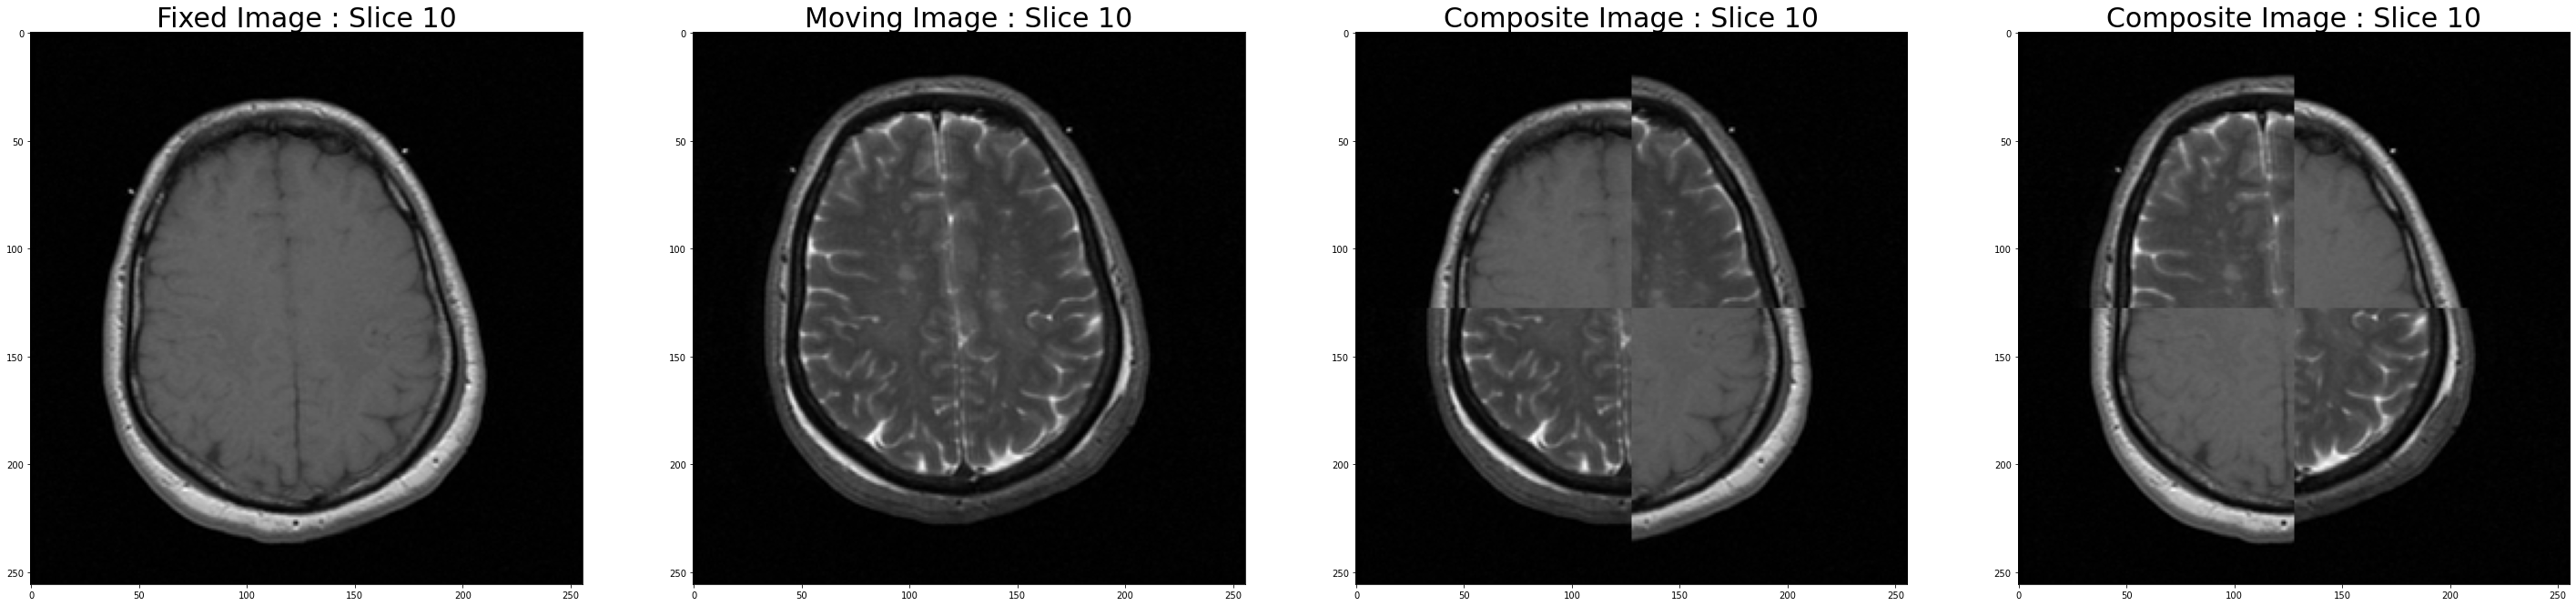

In [89]:
slice = 10
n_regions = 4
comp_1, comp_2 = comp_reg(n_regions, fixed_3d, moving_3d)
fig, ax = plt.subplots(1, 4, figsize = (50, 25))
ax[0].imshow(fixed_3d[slice], cmap='gray'), ax[0].set_title(f'Fixed Image : Slice {slice}',fontsize = 30);
ax[1].imshow(moving_3d[slice], cmap='gray'), ax[1].set_title(f'Moving Image : Slice {slice}',fontsize = 30);
ax[2].imshow(comp_1[slice], cmap='gray'), ax[2].set_title(f'Composite Image : Slice {slice}',fontsize = 30);
ax[3].imshow(comp_2[slice], cmap='gray'), ax[3].set_title(f'Composite Image : Slice {slice}',fontsize = 30);

# Registration

In [110]:
PixelType = itk.F

fixedImage = itk.imread(fixedImageFile, PixelType)
movingImage = itk.imread(movingImageFile, PixelType)

Dimension = fixedImage.GetImageDimension()
FixedImageType = itk.Image[PixelType, Dimension]
MovingImageType = itk.Image[PixelType, Dimension]

print(f"Fixed Image Shape : {fixedImage.shape}")
print(f"Moving Image Shape : {movingImage.shape}")
print(f"Dimension : {Dimension}")

Fixed Image Shape : (33, 256, 256)
Moving Image Shape : (63, 256, 256)
Dimension : 3


## Transform

In [111]:
TransformType = itk.TranslationTransform[itk.D, Dimension]
initialTransform = TransformType.New()

movingInitialTransform = TransformType.New()
initialParameters = movingInitialTransform.GetParameters()
initialParameters[0] = 0
initialParameters[1] = 0
movingInitialTransform.SetParameters(initialParameters)

identityTransform = TransformType.New()
identityTransform.SetIdentity()

## Metric

In [94]:
metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()

In [112]:
MetricType = itk.MattesMutualInformationImageToImageMetricv4[FixedImageType, MovingImageType]
metric = MetricType.New()

numberOfBins = 24
metric.SetNumberOfHistogramBins(numberOfBins)
metric.SetUseMovingImageGradientFilter(False)
metric.SetUseFixedImageGradientFilter(False)

## Optimizer

In [113]:
optimizer = itk.RegularStepGradientDescentOptimizerv4.New(LearningRate=4, MinimumStepLength=0.001, RelaxationFactor=0.5, NumberOfIterations=200)

## Registration

In [114]:
registration = itk.ImageRegistrationMethodv4[FixedImageType, MovingImageType].New(FixedImage=fixedImage, MovingImage=movingImage, Metric=metric, Optimizer=optimizer, InitialTransform=initialTransform)

registration.SetMovingInitialTransform(movingInitialTransform)
registration.SetFixedInitialTransform(identityTransform)

registration.SetNumberOfLevels(1)
registration.SetSmoothingSigmasPerLevel([0])
registration.SetShrinkFactorsPerLevel([1])

## Update

In [115]:
params = []
def iterationUpdate():
    transform = registration.GetTransform()
    currentParameter = transform.GetParameters()
    params.append([optimizer.GetCurrentIteration(), optimizer.GetValue(), currentParameter.GetElement(0), currentParameter.GetElement(1), currentParameter.GetElement(2)])
    print(
        "Iter: %i --> Metric: %f   Translation X: %f, Translation Y: %f, Translation Z: %f"
        % (
            optimizer.GetCurrentIteration(),
            optimizer.GetValue(),
            currentParameter.GetElement(0),
            currentParameter.GetElement(1),
            currentParameter.GetElement(2)
        )
    )


iterationCommand = itk.PyCommand.New()
iterationCommand.SetCommandCallable(iterationUpdate)
optimizer.AddObserver(itk.IterationEvent(), iterationCommand)


0

In [116]:
registration.Update()

transform = registration.GetTransform()
finalParameters = transform.GetParameters()
translationAlongX = finalParameters.GetElement(0)
translationAlongY = finalParameters.GetElement(1)
translationAlongZ = finalParameters.GetElement(2)

numberOfIterations = optimizer.GetCurrentIteration()

bestValue = optimizer.GetValue()

params.append([optimizer.GetCurrentIteration(), optimizer.GetValue(), finalParameters.GetElement(0), finalParameters.GetElement(1), finalParameters.GetElement(2)])


print("Result = ")
print(" Translation X = " + str(translationAlongX))
print(" Translation Y = " + str(translationAlongY))
print(" Translation Z = " + str(translationAlongZ))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))

Iter: 0 --> Metric: -0.363855   Translation X: 0.256409, Translation Y: -3.813188, Translation Z: -1.180615
Iter: 1 --> Metric: -0.470647   Translation X: 0.366235, Translation Y: -7.714076, Translation Z: -2.058688
Iter: 2 --> Metric: -0.628557   Translation X: -1.687360, Translation Y: -11.044031, Translation Z: -1.225537
Iter: 3 --> Metric: -0.537375   Translation X: -0.179787, Translation Y: -9.731233, Translation Z: -1.164040
Iter: 4 --> Metric: -0.609955   Translation X: 0.170345, Translation Y: -7.762874, Translation Z: -1.109538
Iter: 5 --> Metric: -0.632928   Translation X: 0.065918, Translation Y: -8.747871, Translation Z: -1.246928
Iter: 6 --> Metric: -0.641698   Translation X: 0.084300, Translation Y: -8.248325, Translation Z: -1.257681
Iter: 7 --> Metric: -0.646847   Translation X: 0.126899, Translation Y: -8.487026, Translation Z: -1.318566
Iter: 8 --> Metric: -0.645818   Translation X: 0.088192, Translation Y: -8.368174, Translation Z: -1.319516
Iter: 9 --> Metric: -0.64

Text(0, 0.5, 'Metric')

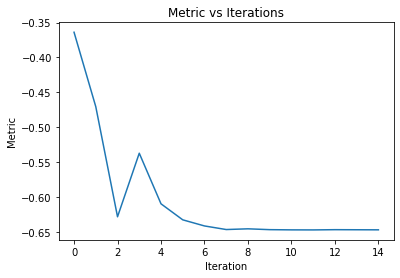

In [127]:
plt.plot(np.array(params)[:,0], np.array(params)[:,1])
plt.title("Metric vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Metric")

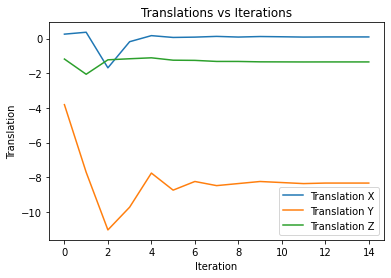

In [128]:
plt.plot(np.array(params)[:,0], np.array(params)[:,2])
plt.plot(np.array(params)[:,0], np.array(params)[:,3])
plt.plot(np.array(params)[:,0], np.array(params)[:,4])
plt.title("Translations vs Iterations")
plt.xlabel("Iteration")
plt.ylabel("Translation")
plt.legend(["Translation X", "Translation Y", "Translation Z"])

In [ ]:
CompositeTransformType = itk.CompositeTransform[itk.D, Dimension]
outputCompositeTransform = CompositeTransformType.New()
outputCompositeTransform.AddTransform(movingInitialTransform)
outputCompositeTransform.AddTransform(registration.GetModifiableTransform())

resampler = itk.ResampleImageFilter.New(Input=movingImage, Transform=outputCompositeTransform, UseReferenceImage=True, ReferenceImage=fixedImage)
resampler.SetDefaultPixelValue(100)
# resampler.Update()

outputImageFile = "/content/drive/MyDrive/ITK Registration/Registered_1.vtk"

OutputPixelType = itk.UC
OutputImageType = itk.Image[OutputPixelType, Dimension]
caster = itk.CastImageFilter[FixedImageType,OutputImageType].New(Input=resampler)
caster_3d = caster.GetOutput()

OutputPixelType = itk.F
OutputImageType = itk.Image[OutputPixelType, Dimension]

writer = itk.ImageFileWriter.New(Input = resampler, FileName = outputImageFile)
writer.SetFileName(outputImageFile)
writer.Update()

out_3d = resampler.GetOutput()

slice = 10
fig, ax = plt.subplots(1,4, figsize=(50,25))
ax[0].imshow(fixed_3d[slice], cmap='gray'), ax[0].set_title('Fixed Image', fontsize = 30)
ax[1].imshow(moving_3d[slice], cmap='gray'), ax[1].set_title('Moving Image', fontsize = 30)
ax[2].imshow(out_3d[slice], cmap='gray'), ax[2].set_title('Registered Image', fontsize = 30)
ax[3].imshow(caster_3d[slice], cmap='gray'), ax[3].set_title('Casted Image', fontsize = 30)

In [ ]:
difference = itk.SubtractImageFilter.New(Input1=fixedImage, Input2=resampler)
intensityRescaler = itk.RescaleIntensityImageFilter[FixedImageType, OutputImageType].New(Input=difference, OutputMinimum=itk.NumericTraits[OutputPixelType].min(),
            OutputMaximum=itk.NumericTraits[OutputPixelType].max())

differenceImageAfterFile = "/content/drive/MyDrive/ITK Registration/differenceImageAfterFile_1.vtk"
differenceImageBeforeFile = "/content/drive/MyDrive/ITK Registration/differenceImageBeforeFile_1.vtk"

resampler.SetDefaultPixelValue(1)
writer.SetInput(intensityRescaler.GetOutput())
writer.SetFileName(differenceImageAfterFile)
writer.Update()
after_diff = intensityRescaler.GetOutput()

resampler_2 = itk.ResampleImageFilter.New(Input=movingImage, Transform=identityTransform, UseReferenceImage=True, ReferenceImage=fixedImage)
difference_2 = itk.SubtractImageFilter.New(Input1=fixedImage, Input2=resampler_2)
intensityRescaler_2 = itk.RescaleIntensityImageFilter[FixedImageType, OutputImageType].New(Input=difference_2, OutputMinimum=itk.NumericTraits[OutputPixelType].min(),
            OutputMaximum=itk.NumericTraits[OutputPixelType].max())
before_diff = intensityRescaler_2.GetOutput()

writer.SetInput(intensityRescaler_2.GetOutput())
writer.SetFileName(differenceImageBeforeFile)
writer.Update()

# Output Visualization

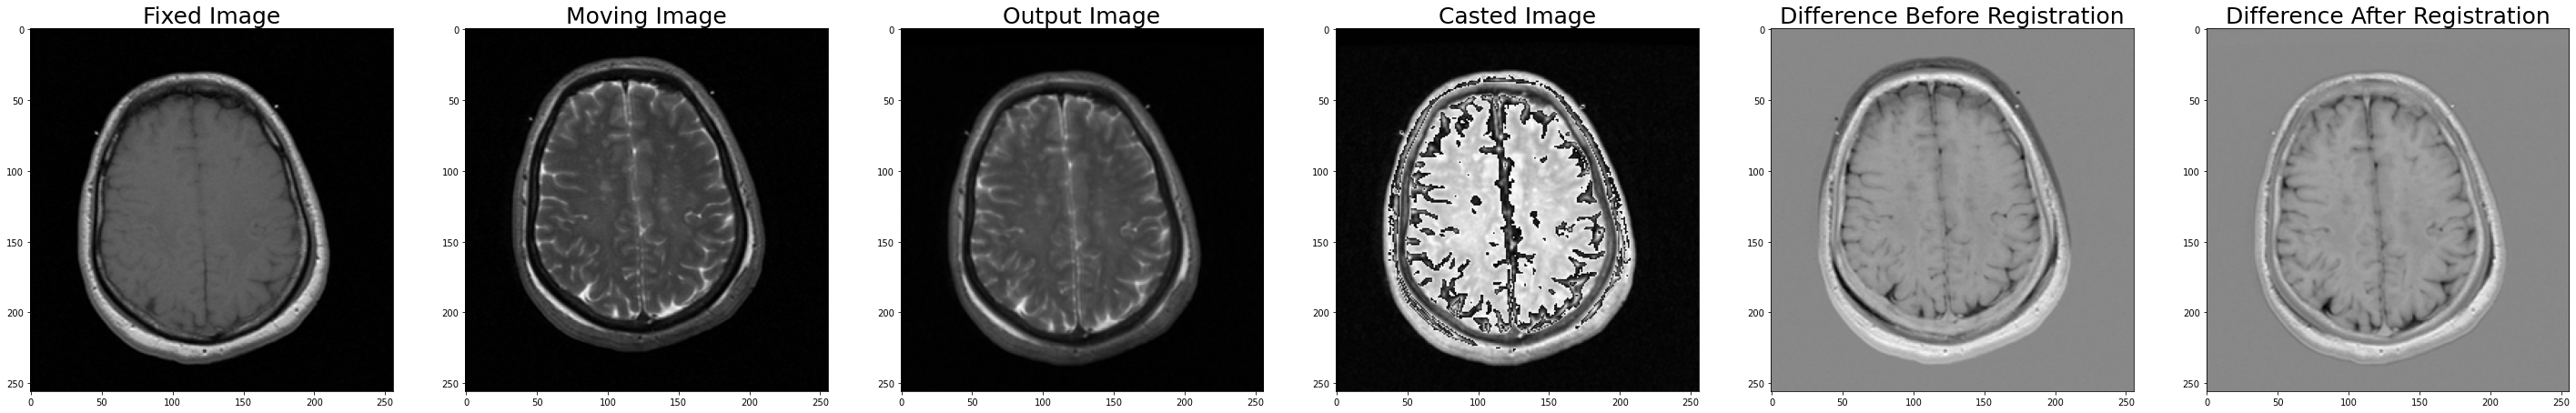

In [18]:
slice = 10
fig, ax = plt.subplots(1,6, figsize=(50,25))
ax[0].imshow(fixed_3d[slice], cmap='gray'), ax[0].set_title('Fixed Image', fontsize = 25)
ax[1].imshow(moving_3d[slice], cmap='gray'), ax[1].set_title('Moving Image', fontsize = 25)
ax[2].imshow(out_3d[slice], cmap='gray'), ax[2].set_title('Output Image', fontsize = 25)
ax[3].imshow(caster_3d[slice], cmap='gray'), ax[3].set_title('Casted Image', fontsize = 25)
ax[4].imshow(before_diff[slice], cmap='gray'), ax[4].set_title('Difference Before Registration', fontsize = 25)
ax[5].imshow(after_diff[slice], cmap='gray'), ax[5].set_title('Difference After Registration', fontsize = 25);

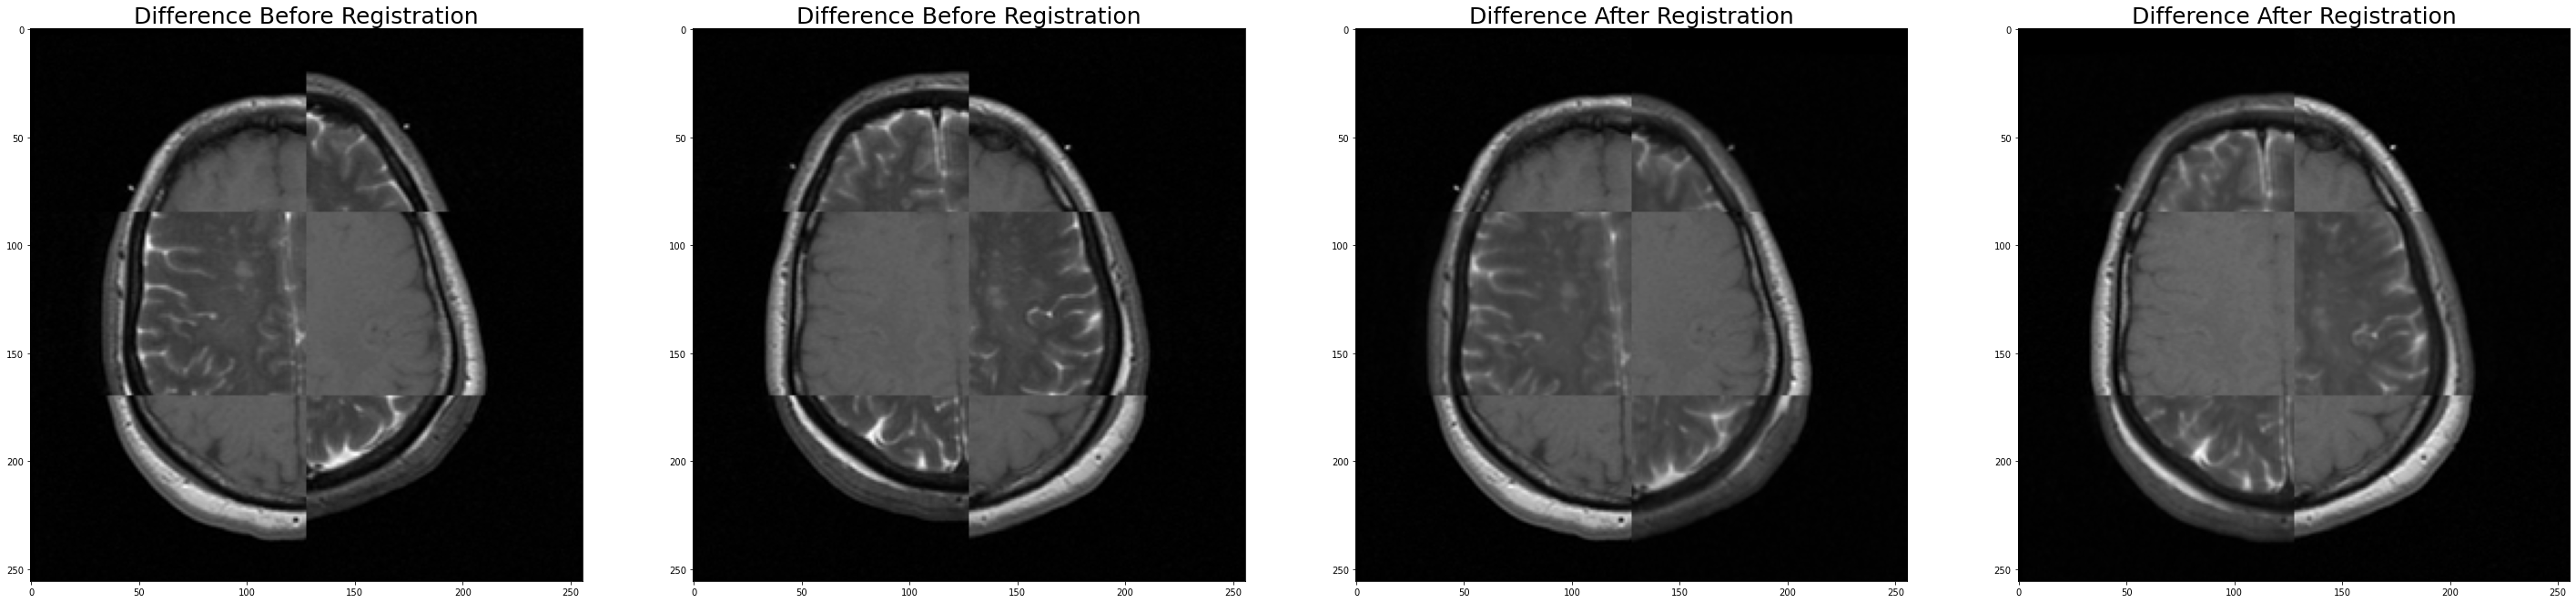

In [90]:
import numpy as np
slice = 10
n_region = 6

before_comp_1, before_comp_2 = comp_reg(n_region, fixed_3d, moving_3d)
after_comp_1, after_comp_2 = comp_reg(n_region, fixed_3d, out_3d)

fig, ax = plt.subplots(1,4, figsize=(50,25))
ax[0].imshow(before_comp_1[slice], cmap='gray'), ax[0].set_title('Difference Before Registration', fontsize = 25)
ax[1].imshow(before_comp_2[slice], cmap='gray'), ax[1].set_title('Difference Before Registration', fontsize = 25)
ax[2].imshow(after_comp_1[slice], cmap='gray'), ax[2].set_title('Difference After Registration', fontsize = 25)
ax[3].imshow(after_comp_2[slice], cmap='gray'), ax[3].set_title('Difference After Registration', fontsize = 25);